In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, precision="double")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [2]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [3]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))

host_w_c, d_w_c = create_var(ne.cell)
host_w_ghost, d_w_ghost = create_var(ne.ghost)
host_w_halo, d_w_halo = create_var(ne.halo)
host_w_haloghost, d_w_haloghost = create_var(ne.haloghost)
host_centerc, d_centerc = create_var(ne.domain.cells.center)
host_centerh, d_centerh = create_var(ne.domain.halos.centvol)
host_cellid, d_cellid = create_var(ne.domain.nodes.cellid)
host_ghostid, d_ghostid = create_var(ne.domain.nodes.ghostid)
host_haloghostid, d_haloghostid = create_var(ne.domain.nodes.haloghostid)
host_periodicid, d_periodicid = create_var(ne.domain.nodes.periodicid)
host_haloid, d_haloid = create_var(ne.domain.nodes.halonid)
host_vertexn, d_vertexn = create_var(ne.domain.nodes.vertex)
host_centergf, d_centergf = create_var(ne.domain.faces.ghostcenter)
host_halocenterg, d_halocenterg = create_var(ne.domain.cells.haloghostcenter)
host_R_x, d_R_x = create_var(ne.domain.nodes.R_x)
host_R_y, d_R_y = create_var(ne.domain.nodes.R_y)
host_R_z, d_R_z = create_var(ne.domain.nodes.R_z)
host_lambda_x, d_lambda_x = create_var(ne.domain.nodes.lambda_x)
host_lambda_y, d_lambda_y = create_var(ne.domain.nodes.lambda_y)
host_lambda_z, d_lambda_z = create_var(ne.domain.nodes.lambda_z)
host_number, d_number = create_var(ne.domain.nodes.number)
host_shift, d_shift = create_var(ne.domain.cells.shift)
host_w_n, d_w_n = create_var(ne.node)
        

In [4]:
len(host_w_n)

53314

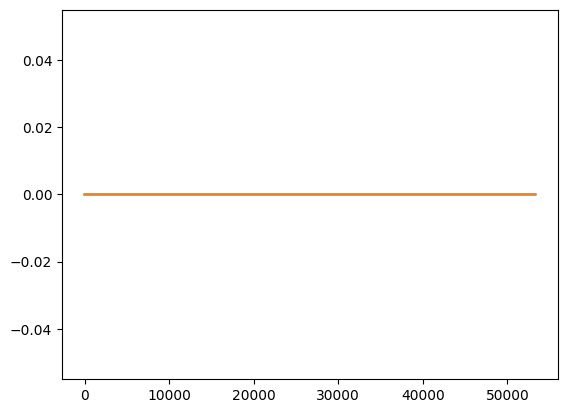

In [7]:
plt.plot(host_w_n)
plt.plot(d_w_n.copy_to_host())
plt.show()

In [8]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def centertovertex_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_haloghost:'float[:]',
                      centerc:'float[:,:]', centerh:'float[:,:]', cellid:'int32[:,:]', ghostid:'int32[:,:]', haloghostid:'int32[:,:]',
                      periodicid:'int32[:,:]',
                      haloid:'int32[:,:]', vertexn:'float[:,:]', centergf:'float[:,:]', halocenterg:'float[:,:]',
                      R_x:'float[:]', R_y:'float[:]', R_z:'float[:]', lambda_x:'float[:]',lambda_y:'float[:]', 
                      lambda_z:'float[:]', number:'uint32[:]', shift:'float[:,:]',  w_n:'float[:]'):
   

    w_n[:] = 0.
    
    nbnode = len(vertexn)
    center = np.zeros(3)
    
    for i in range(nbnode):
        for j in range(cellid[i][-1]):
            cell = cellid[i][j]
            center[:] = centerc[cell][:]
           
            xdiff = center[0] - vertexn[i][0]
            ydiff = center[1] - vertexn[i][1]
            alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
            
            w_n[i]  += alpha * w_c[cell]
            
        for j in range(ghostid[i][-1]):
            cell = ghostid[i][j]
            center[:] = centergf[cell][0:3]
           
            xdiff = center[0] - vertexn[i][0]
            ydiff = center[1] - vertexn[i][1]
            alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
            
            w_n[i]  += alpha * w_ghost[cell]
            
            
        for j in range(haloghostid[i][-1]):
            cell = haloghostid[i][j]
            center[:] = halocenterg[cell][0:3]
          
            xdiff = center[0] - vertexn[i][0]
            ydiff = center[1] - vertexn[i][1]
            
            alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
            
            w_n[i]  += alpha * w_haloghost[cell]
            
        for j in range(haloid[i][-1]):
                cell = haloid[i][j]
                center[:] = centerh[cell][0:3]
              
                xdiff = center[0] - vertexn[i][0]
                ydiff = center[1] - vertexn[i][1]
                alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
             
                w_n[i]  += alpha * w_halo[cell]
                
        #TODO Must be keeped like that checked ok ;)
        if vertexn[i][3] == 11 or vertexn[i][3] == 22 :
            for j in range(periodicid[i][-1]):
                cell = periodicid[i][j]
                center[:] = centerc[cell][0:3] 
                
                xdiff = center[0] + shift[cell][0] - vertexn[i][0]
                ydiff = center[1] - vertexn[i][1]
                alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
                
                w_n[i]  += alpha * w_c[cell]
                    
        elif vertexn[i][3] == 33 or vertexn[i][3] ==44:
            for j in range(periodicid[i][-1]):
                cell = periodicid[i][j]
                center[:] = centerc[cell][0:3] 
                
                xdiff = center[0] - vertexn[i][0]
                ydiff = center[1] + shift[cell][1] - vertexn[i][1]
                alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
                
                w_n[i]  += alpha * w_c[cell]



In [9]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_centertovertex_2d = numba.jit(centertovertex_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_numba_centertovertex_2d():
  numba_centertovertex_2d(
    host_w_c,
    host_w_ghost,
    host_w_halo,
    host_w_haloghost,
    host_centerc,
    host_centerh,
    host_cellid,
    host_ghostid,
    host_haloghostid,
    host_periodicid,
    host_haloid,
    host_vertexn,
    host_centergf,
    host_halocenterg,
    host_R_x,
    host_R_y,
    host_R_z,
    host_lambda_x,
    host_lambda_y,
    host_lambda_z,
    host_number,
    host_shift,
    host_w_n,
  )


In [10]:
#time taken by cpu_numba_centertovertex_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_numba_centertovertex_2d()

8.64 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
host_haloghostid[0]

array([0, 0], dtype=int32)

In [18]:
@cuda.jit
def kernel_centertovertex_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]', w_haloghost:'float[:]',
                      centerc:'float[:,:]', centerh:'float[:,:]', cellid:'int32[:,:]', ghostid:'int32[:,:]', haloghostid:'int32[:,:]',
                      periodicid:'int32[:,:]',
                      haloid:'int32[:,:]', vertexn:'float[:,:]', centergf:'float[:,:]', halocenterg:'float[:,:]',
                      R_x:'float[:]', R_y:'float[:]', R_z:'float[:]', lambda_x:'float[:]',lambda_y:'float[:]', 
                      lambda_z:'float[:]', number:'uint32[:]', shift:'float[:,:]',  w_n:'float[:]'):
   
    i = cuda.grid(1)

    if i >= vertexn.shape[0]:
      return

    w_n[i] = 0.
    
  
    for j in range(cellid[i][-1]):
      cell = cellid[i][j]
      #!center[:] = centerc[cell][:]
      
      xdiff = centerc[cell][0] - vertexn[i][0]
      ydiff = centerc[cell][1] - vertexn[i][1]
      alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
      
      w_n[i]  += alpha * w_c[cell]
        
    for j in range(ghostid[i][-1]):
      cell = ghostid[i][j]
      #!center[:] = centergf[cell][0:3]
      
      xdiff = centergf[cell][0] - vertexn[i][0]
      ydiff = centergf[cell][1] - vertexn[i][1]
      alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
      
      w_n[i]  += alpha * w_ghost[cell]
        
        
    for j in range(haloghostid[i][-1]):
      cell = haloghostid[i][j]
      #!center[:] = halocenterg[cell][0:3]
    
      xdiff = halocenterg[cell][0] - vertexn[i][0]
      ydiff = halocenterg[cell][1] - vertexn[i][1]
      
      alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
      
      w_n[i]  += alpha * w_haloghost[cell]
      
    for j in range(haloid[i][-1]):
      cell = haloid[i][j]
      #!center[:] = centerh[cell][0:3]
    
      xdiff = centerh[cell][0] - vertexn[i][0]
      ydiff = centerh[cell][1] - vertexn[i][1]
      alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
    
      w_n[i]  += alpha * w_halo[cell]
            
    #TODO Must be keeped like that checked ok ;)
    if vertexn[i][3] == 11 or vertexn[i][3] == 22 :
      for j in range(periodicid[i][-1]):
        cell = periodicid[i][j]
        #!center[:] = centerc[cell][0:3] 
        
        xdiff = centerc[cell][0] + shift[cell][0] - vertexn[i][0]
        ydiff = centerc[cell][1] - vertexn[i][1]
        alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
        
        w_n[i]  += alpha * w_c[cell]
                
    elif vertexn[i][3] == 33 or vertexn[i][3] ==44:
      for j in range(periodicid[i][-1]):
        cell = periodicid[i][j]
        #!center[:] = centerc[cell][0:3] 
        
        xdiff =  centerc[cell][0] - vertexn[i][0]
        ydiff =  centerc[cell][1] + shift[cell][1] - vertexn[i][1]
        alpha = (1. + lambda_x[i]*xdiff + lambda_y[i]*ydiff)/(number[i] + lambda_x[i]*R_x[i] + lambda_y[i]*R_y[i])
        
        w_n[i]  += alpha * w_c[cell]




def cuda_numba_centertovertex_2d():
  nb_element = len(d_vertexn)
  nb_threads = 32
  nb_blocks = nb_element // 32 + 1


  kernel_centertovertex_2d[nb_blocks, nb_threads](
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_w_haloghost,
    d_centerc,
    d_centerh,
    d_cellid,
    d_ghostid,
    d_haloghostid,
    d_periodicid,
    d_haloid,
    d_vertexn,
    d_centergf,
    d_halocenterg,
    d_R_x,
    d_R_y,
    d_R_z,
    d_lambda_x,
    d_lambda_y,
    d_lambda_z,
    d_number,
    d_shift,
    d_w_n,
  )
  cuda.synchronize()

test_time(700, cuda_numba_centertovertex_2d)

3.32850 ms


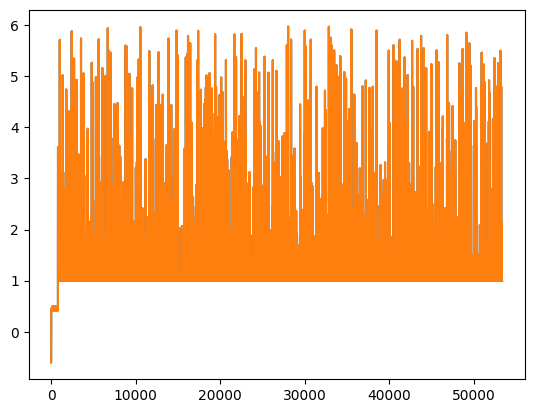

In [19]:
def verify(a, b):
  b = b.copy_to_host()
  plt.plot(a)
  plt.plot(b)

  #assert
  np.testing.assert_almost_equal(a, b, decimal=2, )
  plt.show()

verify(host_w_n, d_w_n)